# Spark
[http://spark.apache.org/docs/2.1.0/api/python/pyspark.html](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html)

## Installation
- Install GOW
    - [https://github.com/bmatzelle/gow/releases](https://github.com/bmatzelle/gow/releases)
- Install Spark
    - [https://www.apache.org/dyn/closer.lua/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz](https://www.apache.org/dyn/closer.lua/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz)
    - create a directory to hold the spark installation, and move the downloaded .tgz file there
    - navigate to that directory in the command prompt
    - upzip using `gzip -d filename.tgz`
    - untar using `tar xvf filename.tar`
    - navigate to the new spark folder in the cmd prompt
    - cd into bin and add winutils using command below
    - `curl -k -L -o winutils.exe https://github.com/steveloughran/winutils/tree/master/hadoop-3.0.0/bin/winutils.exe?raw=true`
    - ensure Java 8 is installed to path [https://medium.com/big-data-engineering/how-to-install-apache-spark-2-x-in-your-pc-e2047246ffc3](https://medium.com/big-data-engineering/how-to-install-apache-spark-2-x-in-your-pc-e2047246ffc3)
    - in command prompt, set spark variables
    - `setx SPARK_HOME C:Spark\spark-2.4.4-bin-hadoop2.7`
    - `setx HADOOP_HOME C:Spark\spark-2.4.4-bin-hadoop2.7`
    - `setx PYSPARK_DRIVER_PYTHON jupyter`
    - `setx PYSPARK_DRIVER_PYTHON_OPTS lab`
    - add `C:\Spark\spark-2.4.4-bin-hadoop2.7\bin` to the PATH variables

## Launching PySpark
- Launching from anaconda prompt `pyspark --master local[2]`
    - launches on the local machine with 2 cores
        - `pyspark` will also launch
    - test it with the code below or run the simple word counter program

In [1]:
# test pyspark connection
sc = SparkContext.getOrCreate()

In [2]:
import numpy as np

TOTAL = 1000000
dots = sc.parallelize([2.0 * np.random.random(2) - 1.0 for i in range(TOTAL)]).cache()
print("Number of random points:", dots.count())

stats = dots.stats()
print('Mean:', stats.mean())
print('stdev:', stats.stdev())

Number of random points: 1000000
Mean: [-4.50404993e-06 -7.05333041e-04]
stdev: [0.57714096 0.57690564]


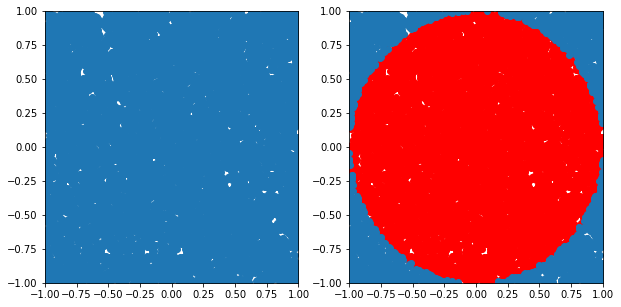

In [3]:
%matplotlib inline
from operator import itemgetter
from matplotlib import pyplot as plt

plt.figure(figsize = (10, 5))

# Plot 1
plt.subplot(1, 2, 1)
plt.xlim((-1.0, 1.0))
plt.ylim((-1.0, 1.0))

sample = dots.sample(False, 0.01)
X = sample.map(itemgetter(0)).collect()
Y = sample.map(itemgetter(1)).collect()
plt.scatter(X, Y)

# Plot 2
plt.subplot(1, 2, 2)
plt.xlim((-1.0, 1.0))
plt.ylim((-1.0, 1.0))

inCircle = lambda v: np.linalg.norm(v) <= 1.0
dotsIn = sample.filter(inCircle).cache()
dotsOut = sample.filter(lambda v: not inCircle(v)).cache()

# inside circle
Xin = dotsIn.map(itemgetter(0)).collect()
Yin = dotsIn.map(itemgetter(1)).collect()
plt.scatter(Xin, Yin, color = 'r')

# outside circle
Xout = dotsOut.map(itemgetter(0)).collect()
Yout = dotsOut.map(itemgetter(1)).collect()
plt.scatter(Xout, Yout)

## Spark Framework
- Platform for cluster computing
- Data is spread over multiple nodes in each cluster
    - each node only handles a small amount of data, increasing speed
    - results in parallel computing, as computations are carried out simultaneously
- Considerations
    - is my data too big for one machine?
    - can my computations be easily parallelized?

## Connecting to a Cluster
- The master computer is connected to all other nodes
    - this manages the data and splits up the calculations
- The other computers in the cluster are workers
    - workers get data and calculations to run from the master
    - they return the results to the master
- Create an instance of the `SparkContext` class

## Spark Data Structures
- The Resilient Distributed Dataset (RDD) is spark's core data structure
    - this lets spark split the data across multiple nodes in a cluster
    - RDD's are hard to work with directly
- Spark Dataframe abstraction
    - built on top of RDD
    - easier to use than direct RDD's

In [4]:
# simple word counter
rdd = sc.textFile('Spark_Course/Marvel-names.txt')

rdd.count()

19428

## Working with Spark Dataframes
- Create a `SparkSession` from the `SparkContext`
    - `SparkContext` is the connection to the cluster
    - `SparkSession` is the interface to that connection

## Creating a Spark Session
- Creating multiple sessions and contexts can cause issues
    - the `SparkSession.builder.getOrCreate()` method will return an existing session if there is one, and create one if there isn't one yet

In [5]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

# Create my_spark
my_spark = SparkSession.builder.getOrCreate()

# Print my_spark
print(my_spark)

## Working with Spark Sessions
- `.sql(query)` will run a sql like query
- `.toPandas()` will store results in a pandas dataframe
- `.createDataFrame()` takes a pandas dataframe and returns a spark dataframe
- `spark.read.csv(file_path, header=True)` read in files to a dataframe
- `sdf.show()` show the contents of a spark dataframe

## Frank Kane's Spark Course
- Book available from Packt and on Amazon

In [3]:
# simple movie ratings counter

from pyspark import SparkConf, SparkContext
import collections

# set master node as local machine, run on a single thread (no distribution of processes)
# set the name of the app (good practice allows to check in spark web UI)
conf = SparkConf().setMaster('local').setAppName('RatingsHistogram')
# set the sparkcontext
sc = SparkContext.getOrCreate(conf = conf)

# read in the lines of the data file (each line is one item)
lines = sc.textFile('Spark_Course/ml-100k/u.data')
# split the lines by spaces (which contain 4 items) but only return the third item (index 2)
ratings = lines.map(lambda x: x.split()[2])
# similar to .value_counts() in pandas
result = ratings.countByValue()

# sort the results by the index (rating) and print the index along with its count
sortedResults = collections.OrderedDict(sorted(result.items()))
for k, v in sortedResults.items():
    print('%s: %i' % (k, v))

1: 6110
2: 11370
3: 27145
4: 34174
5: 21201


## Spark Basics

### Spark Context
- Spark Context is where you need to start
    - provides methods to create RDDs

### Resilient Distributed Dataset (RDD)

#### Hardcoding RDDs
- Not done often because can't do to create a large dataset needing spark
- Syntax
```python
# where x is your data (like a list)
rdd = sc.parallelize(x)
```

#### Other More Common Methods
- Distributed file systems
    - s3n
    - HDFS URI
- Hive
    - need a HiveContext object connected to an existing Hive repo
```python
hiveCtx = HiveContext(s)
rows = hiveCtx.sql('SELECT col1, col2 FROM tbl')
```

#### Transforming RDDs
- map
    - `rdd.map(function)`
        - `function` can be a lambda function, built-in function, or user defined function
        - just like pandas map function
- flatmap
- filter
- distinct
- sample
- union
- intersection
- subtract
- cartesian

#### RDD Actions
- collect
- count
- countByValue
- take
- top
- reduct